In [1]:
import pandas as pd
import statsmodels as stat
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from skimpy import skim

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import clone
import xgboost as xgb
import numpy as np
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix
import shap

dtypes_df = pd.read_csv('./train_dtypes.csv')
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
df = pd.read_csv('./train_0.csv', dtype=dtypes, iterator=True, chunksize=400_000)
test = pd.read_csv('./test.csv')

df0 = next(df)
skim(df0)
skim(test)


/home/mchz/anaconda3/envs/poker/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 400000 │ │ float64     │ 55    │                                                          │
│ │ Number of columns │ 61     │ │ int64       │ 5     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA    ┃ NA %  ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ game_num                 │     0 │     0 │      71 │     40 │      1 │     36 │     100 │     140 │ ▇▇▇███ │  │
│ │ event_id                 │     0 │     0 │   71000 │  40000 │   1000 │  36000 │  110000 │  140000 │ ▇█▇▇██ │  │
│ │ event_time               │     0 │     0 │     -65 │     63 │   -470 │    -91 │     -19 │  -0.033 │    ▁▂█ │  │
│ │ ball_pos_x               │     0 │     0 │  0.0024 │     49 │    -81 │    -45 │      45 │      81 │ █▆▆▇▆█ │  │
│ │ ball_pos_y               │     0 │     0 │     0.3 │     60 │   -100 │    -53 │      54 │     100 │ █▇█▇▇█ │  │
│ │ ball_pos_z               │     0 │     0 │      16 │     10 │    1.6 │    6.5 │      24 │      39 │ █▅▅▄▃▂ │  │
│ │ ball_vel_x               │     0 │     0 │  0.0023 │     23 │    -99 │    -15 │      16 │      98 │  ▁▇█▁  │  │
│ │ ball_vel_y               │     0 │     0 │    0.02 │     28 │    -86 │    -22 │      22 │      82 │  ▄▇█▅  │  │
│ │ ball_vel_z               │     0 │     0 │    0.12 │     12 │    -49 │   -7.7 │     7.7 │      68 │   ▂█▃  │  │
│ │ p0_pos_x                 │  3400 │  0.85 │   -0.21 │     46 │    -82 │    -38 │      38 │      82 │ ▇▇██▇▇ │  │
│ │ p0_pos_y                 │  3400 │  0.85 │     -19 │     59 │   -120 │    -72 │      25 │     120 │ ▇█▇▇▄▃ │  │
│ │ p0_pos_z                 │  3400 │  0.85 │     3.4 │    6.4 │  0.027 │   0.34 │     2.5 │      41 │   █▁   │  │
│ │ p0_vel_x                 │  3400 │  0.85 │   0.017 │     21 │    -46 │    -16 │      16 │      46 │ ▃▆██▆▃ │  │
│ │ p0_vel_y                 │  3400 │  0.85 │       1 │     24 │    -46 │    -19 │      21 │      46 │ ▅▅▆█▇▄ │  │
│ │ p0_vel_z                 │  3400 │  0.85 │   0.052 │    6.3 │    -46 │   -0.3 │   0.011 │      45 │    ▃█  │  │
│ │ p0_boost                 │  3400 │  0.85 │      46 │     34 │      0 │     13 │      77 │     100 │ █▄▄▃▄▆ │  │
│ │ p1_pos_x                 │  3500 │  0.87 │   -0.69 │     46 │    -82 │    -38 │      37 │      82 │ ▇▇██▆▆ │  │
│ │ p1_pos_y                 │  3500 │  0.87 │     -20 │     59 │   -120 │    -72 │      24 │     120 │ ▇█▇▆▄▃ │  │
│ │ p1_pos_z                 │  3500 │  0.87 │     3.5 │    6.5 │  0.038 │   0.34 │     2.6 │      41 │   █▁   │  │
│ │ p1_vel_x                 │  3500 │  0.87 │   0.021 │     21 │    -46 │    -16 │      16 │      46 │ ▃▆██▆▂ │  │
│ │ p1_vel_y                 │  3500 │  0.87 │       1 │     25 │    -46 │    -19 │      21 │      46 │ ▅▅▆█▇▄ │  │
│ │ p1_vel_z                 │  3500 │  0.87 │   0.048 │

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 701143 │ │ float64     │ 54    │                                                          │
│ │ Number of columns │ 55     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA     ┃ NA %   ┃ mean     ┃ sd       ┃ p0        ┃ p25     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ id              │      0 │      0 │   350000 │   200000 │         0 │  180000 │  530000 │  700000 │ ██████ │  │
│ │ ball_pos_x      │      0 │      0 │    0.057 │       49 │       -81 │     -44 │      45 │      81 │ █▆▆▇▆█ │  │
│ │ ball_pos_y      │      0 │      0 │    0.073 │       60 │      -100 │     -53 │      53 │     100 │ █▇▇█▇█ │  │
│ │ ball_pos_z      │      0 │      0 │       16 │       10 │       1.6 │     6.4 │      24 │      39 │ █▅▅▄▃▂ │  │
│ │ ball_vel_x      │      0 │      0 │   -0.058 │       23 │      -100 │     -16 │      16 │     110 │  ▁█▆▁  │  │
│ │ ball_vel_y      │      0 │      0 │    0.054 │       28 │       -93 │     -22 │      22 │      89 │  ▃▇█▄  │  │
│ │ ball_vel_z      │      0 │      0 │     0.13 │       12 │       -59 │    -7.6 │     7.6 │      96 │   ▃█▁  │  │
│ │ p0_pos_x        │   6300 │    0.9 │    0.026 │       46 │       -82 │     -37 │      37 │      82 │ ▆▇██▇▆ │  │
│ │ p0_pos_y        │   6300 │    0.9 │      -20 │       58 │      -120 │     -72 │      23 │     120 │ ▇██▆▄▂ │  │
│ │ p0_pos_z        │   6300 │    0.9 │      3.5 │      6.5 │     0.045 │    0.34 │     2.5 │      41 │   █▁   │  │
│ │ p0_vel_x        │   6300 │    0.9 │   -0.027 │       21 │       -46 │     -16 │      16 │      46 │ ▃▆██▆▃ │  │
│ │ p0_vel_y        │   6300 │    0.9 │        1 │       24 │       -46 │     -18 │      21 │      46 │ ▅▅▆█▇▄ │  │
│ │ p0_vel_z        │   6300 │    0.9 │    0.048 │      6.3 │       -46 │    -0.3 │   0.011 │      42 │    ▁█  │  │
│ │ p0_boost        │   6300 │    0.9 │       46 │       34 │         0 │      13 │      77 │     100 │ █▄▄▃▄▆ │  │
│ │ p1_pos_x        │   6200 │   0.88 │    0.055 │       45 │       -82 │     -37 │      37 │      82 │ ▆▇██▇▆ │  │
│ │ p1_pos_y        │   6200 │   0.88 │      -19 │       58 │      -120 │     -72 │      23 │     120 │ ▇██▆▄▂ │  │
│ │ p1_pos_z        │   6200 │   0.88 │      3.5 │      6.5 │   -0.0028 │    0.34 │     2.5 │      41 │   █▁   │  │
│ │ p1_vel_x        │   6200 │   0.88 │    -0.05 │       21 │       -46 │     -16 │      16 │      46 │ ▃▆██▆▃ │  │
│ │ p1_vel_y        │   6200 │   0.88 │        1 │       24 │       -46 │     -18 │      21 │      46 │ ▅▅▆█▇▄ │  │
│ │ p1_vel_z        │   6200 │   0.88 │    0.043 │      6.3 │       -42 │    -0.3 │   0.011 │      45 │    █▂  │  │
│ │ p1_boost        │   6200 │   0.88 │       46 │       34 │         0 │      13 │      77 │     100 │ █▄▄▃▄▆ │  │
│ │ p2_pos_x        │   6200 │   0.88 │    0.059 │       46 │       -82 │     -37 │      37 │      82 │ ▆▇██▇▆ │  │
│ │ p2_pos_y        │   6200 │   0.88 │      -19 │      

In [19]:
df0.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.804798,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.261600,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.227001,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993191,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.898399,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.960602,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


##### Files
- train_[0-9].csv
- test.csv
- [train|test]_dtypes.csv
- sample_submission.csv
##### Columns
- game_num (train only): **redundant col**
- event_id (train only): **redundant col**
- event_time (train only): **redundant col**
- ball_pos_[xyz] 
- ball_vel_[xyz]
##### All NaN in p{i} means that player is demolished
- p{i}_pos_[xyz]
- p{i}_vel_[xyz]
- p{i}_boost
###### 
- boost{i}
- player_scoring_next (train only): **redundant col**
- team_scoring_next (train only): **redundant col**
- team_[A|B]_scoring_within_10sec (train only) : **label**
- id (test only)
 


## EDA

#### Quasi-constant and constant columns
If numerical column has variance smaller then threshold then we can remove such column because it doesn't contain any useful information.

([<matplotlib.patches.Wedge at 0x7ff5f13d06d0>,
 [Text(-1.0334093101704251, 0.3769153720042287, 'no score'),
  Text(0.9499139262376382, -0.5546742582271104, 'A score'),
  Text(1.0824683338569843, -0.1956075310331496, 'B score')])

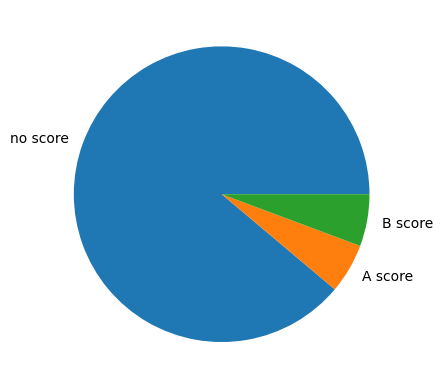

In [52]:
balance = df0.groupby(["team_A_scoring_within_10sec", "team_B_scoring_within_10sec"]).apply(len)
plt.pie(balance, labels = ["no score", "A score", "B score"])

In [2]:
df0.drop(["event_id", "event_time", "game_num", "team_scoring_next", "player_scoring_next"], axis=1, inplace=True)
df0.dropna(inplace=True)

In [3]:
X = df0.drop(["team_A_scoring_within_10sec", "team_B_scoring_within_10sec"], axis=1)
y = df0[["team_A_scoring_within_10sec", "team_B_scoring_within_10sec"]]

#### Correlation Pearson and Spearman
Main goal is to find similar featchers or attributes not correlated with labels

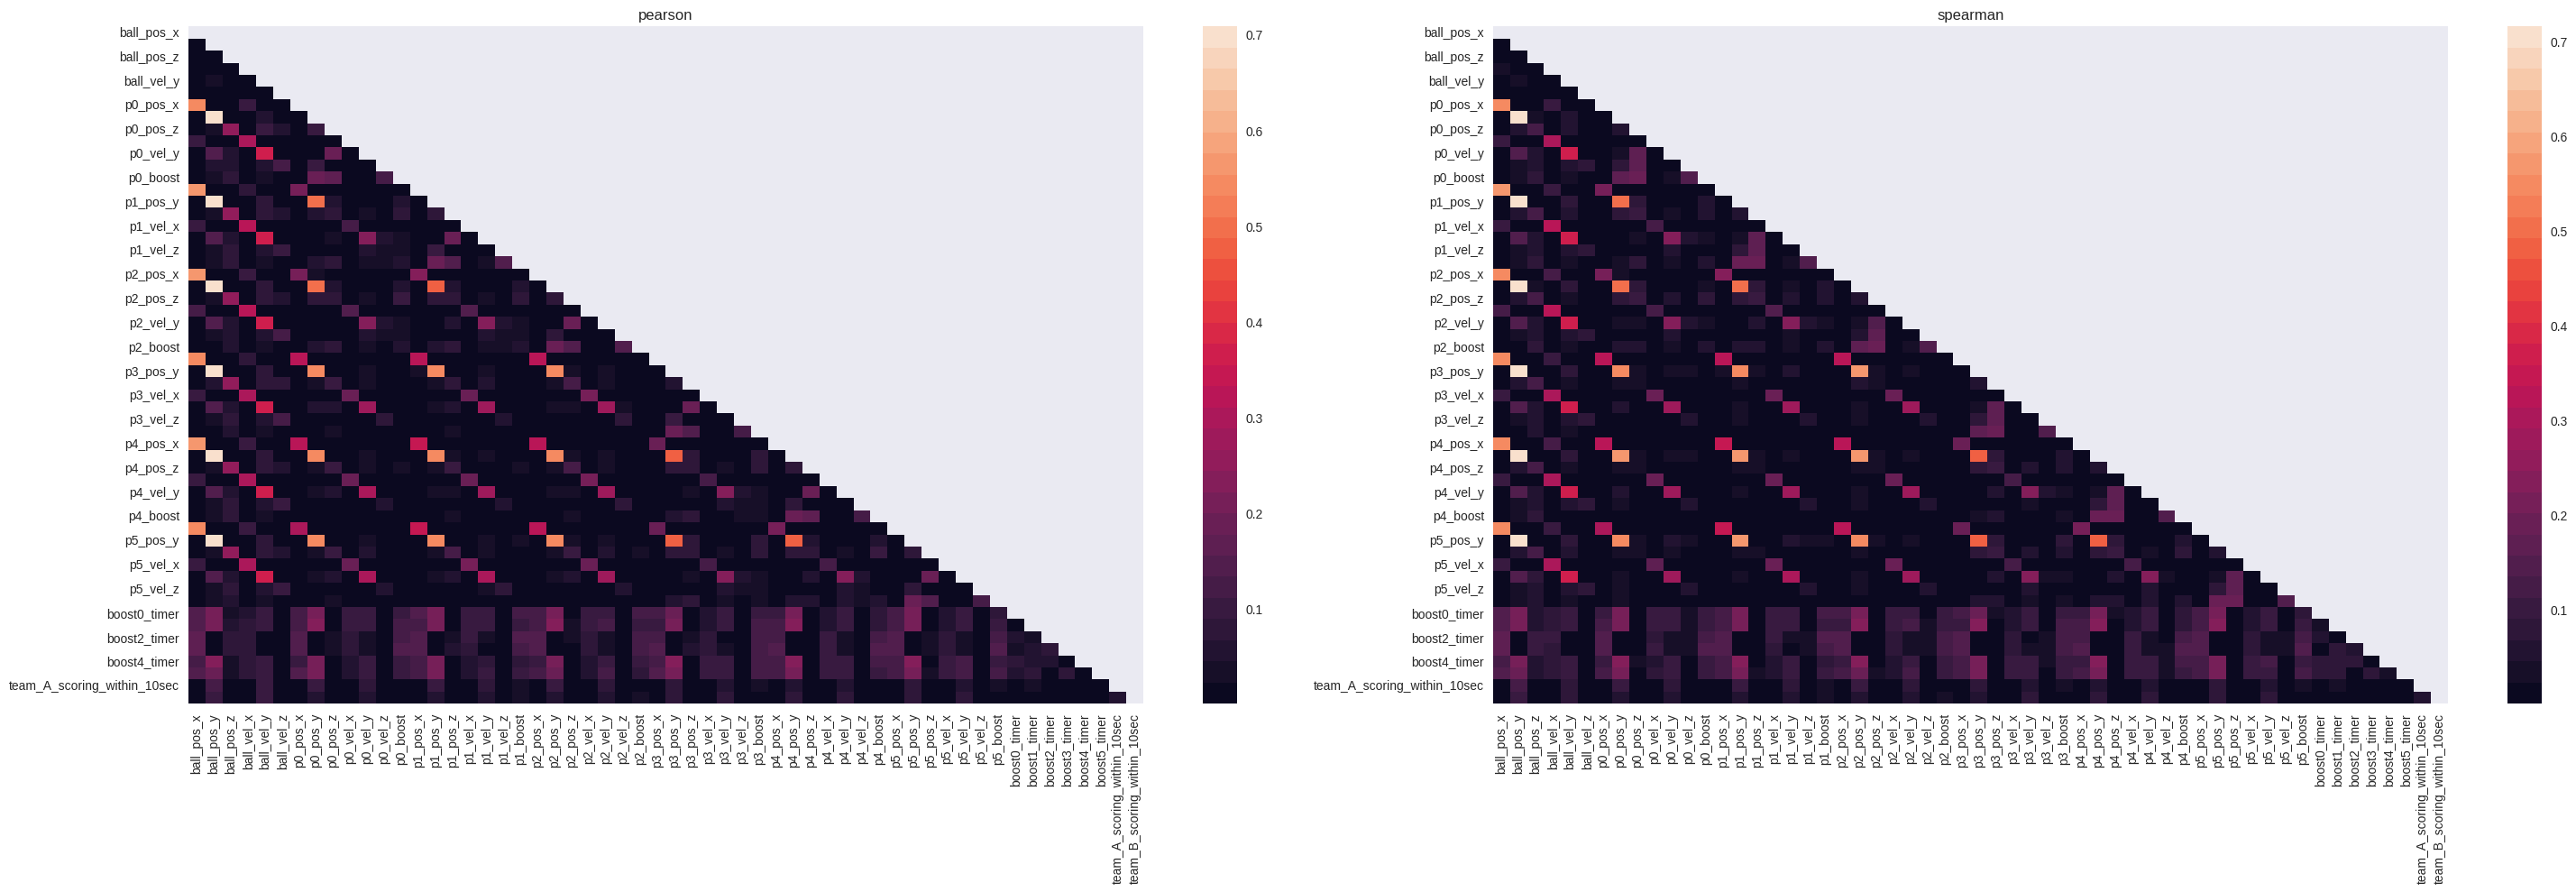

In [82]:
pal=sns.color_palette("rocket",32)

rp = df0.dropna().corr(method=lambda x, y: np.abs(pearsonr(x,y)[0]))
rs = df0.dropna().corr(method=lambda x, y: np.abs(spearmanr(x,y)[0]))

mask = np.triu(np.ones_like(rp, dtype=bool))
rp = rp.mask(mask)
rs = rs.mask(mask)

fig, ax = plt.subplots(1,2)
fig.set_figwidth(30)
fig.set_figheight(10)
sns.heatmap(rp, cmap=pal, ax=ax[0]).set(title="pearson")
sns.heatmap(rs, cmap=pal, ax=ax[1]).set(title="spearman")
fig.tight_layout()
plt.show()

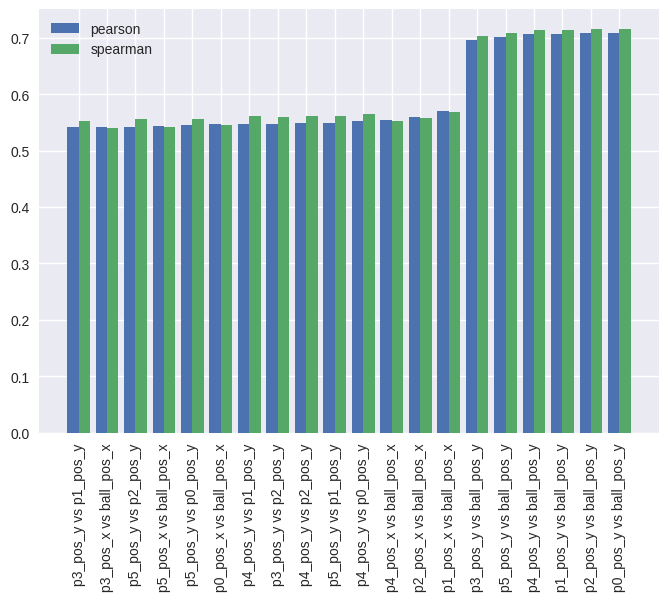

In [83]:
bars_p = defaultdict()
comb = combinations(X.columns, 2)

for col1, col2 in [*comb]:
    r = rp.loc[col2, col1]
    bars_p[f"{col2} vs {col1}"] = r

bars_p = dict(sorted(bars_p.items(), key=lambda x: x[1])[-20:])
bars_s = [rs.loc[key.split(" vs ")[0], key.split(" vs ")[1]] for key in bars_p.keys()]

plt.bar(np.arange(len(bars_p.keys())) -.2, bars_p.values(), 0.4, label="pearson")
plt.bar(np.arange(len(bars_p.keys())) + .2, bars_s, 0.4, label="spearman")
plt.xticks(np.arange(len(bars_p.keys())), bars_p.keys(), rotation=90)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation with B target')

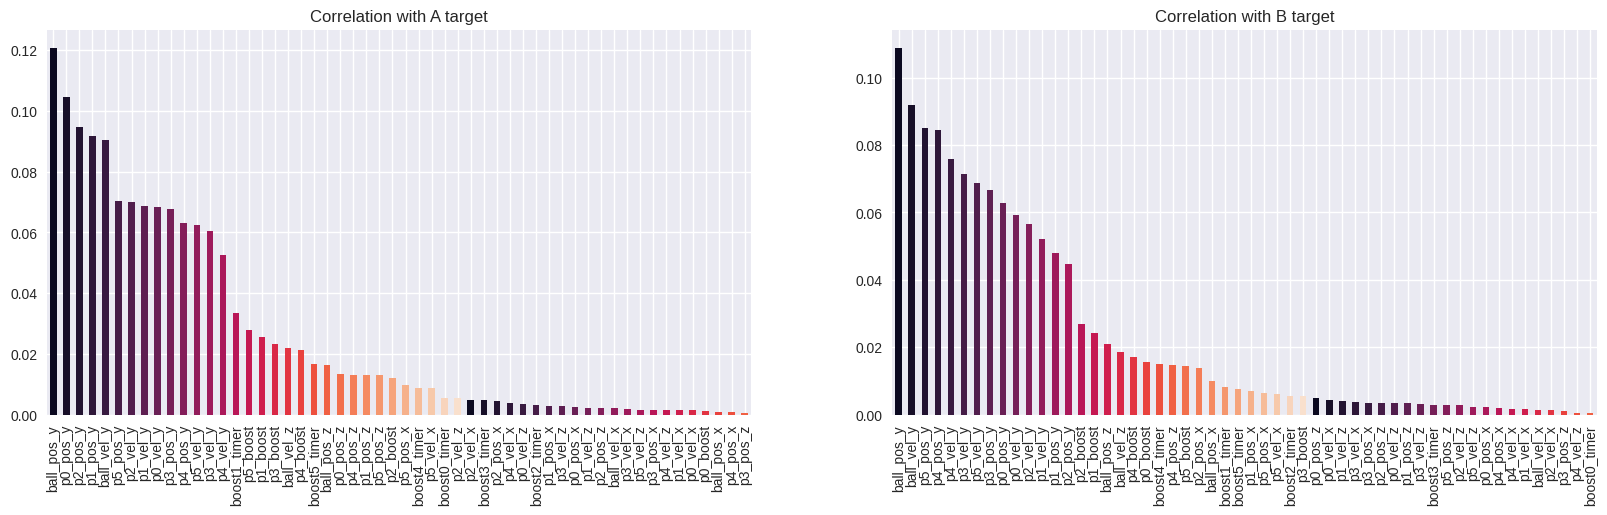

In [79]:
rsB=rp.iloc[-1,:-2].sort_values(ascending=False)
rsA=rp.iloc[-2,:-2].sort_values(ascending=False)
_, ax = plt.subplots(1,2)
rsA.plot.bar(color=pal, figsize=(20,5), ax=ax[0]).set_title("Spearman corr with A target")
rsB.plot.bar(color=pal, figsize=(20,5), ax=ax[1]).set_title("Spearman corr with B target")

In [7]:
X.head()

,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,...,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer
361108,33.982399,-74.757996,27.566999,-8.940400,12.329399,-2.2194,-3.339200,-91.574806,1.5588,-30.158602,...,-15.393001,-10.240000,14.3144,44.906250,-1.583008,-0.200317,0.000000,-3.382812,0.000000,0.000000
398288,-73.052597,-52.897404,25.001799,32.541798,-13.599800,0.2660,0.390800,-58.940201,0.3402,20.209000,...,-12.153001,-34.119400,0.0042,30.203125,0.000000,-6.722656,-4.742188,-0.207764,-0.963867,-2.332031
47601,-1.692400,-85.645996,2.090200,1.243800,14.284000,5.9042,-17.708199,-87.027000,0.3404,40.158600,...,-29.270802,-2.620600,-0.0008,83.437500,-8.062500,-8.062500,-2.064453,-6.964844,0.000000,0.000000
95492,-73.066605,-10.090800,2.993800,37.167999,-26.941599,17.1322,-64.924202,-26.754999,4.8098,-26.601599,...,34.505199,29.979198,-5.1028,8.625000,0.000000,0.000000,-8.070312,0.000000,0.000000,0.000000
183923,79.024002,61.385201,8.092199,-22.445400,-19.196600,2.8328,-70.442795,0.271200,0.3402,-40.401001,...,21.986200,17.588001,0.7998,52.562500,-1.619141,0.000000,-9.898438,-5.125000,0.000000,-5.425781


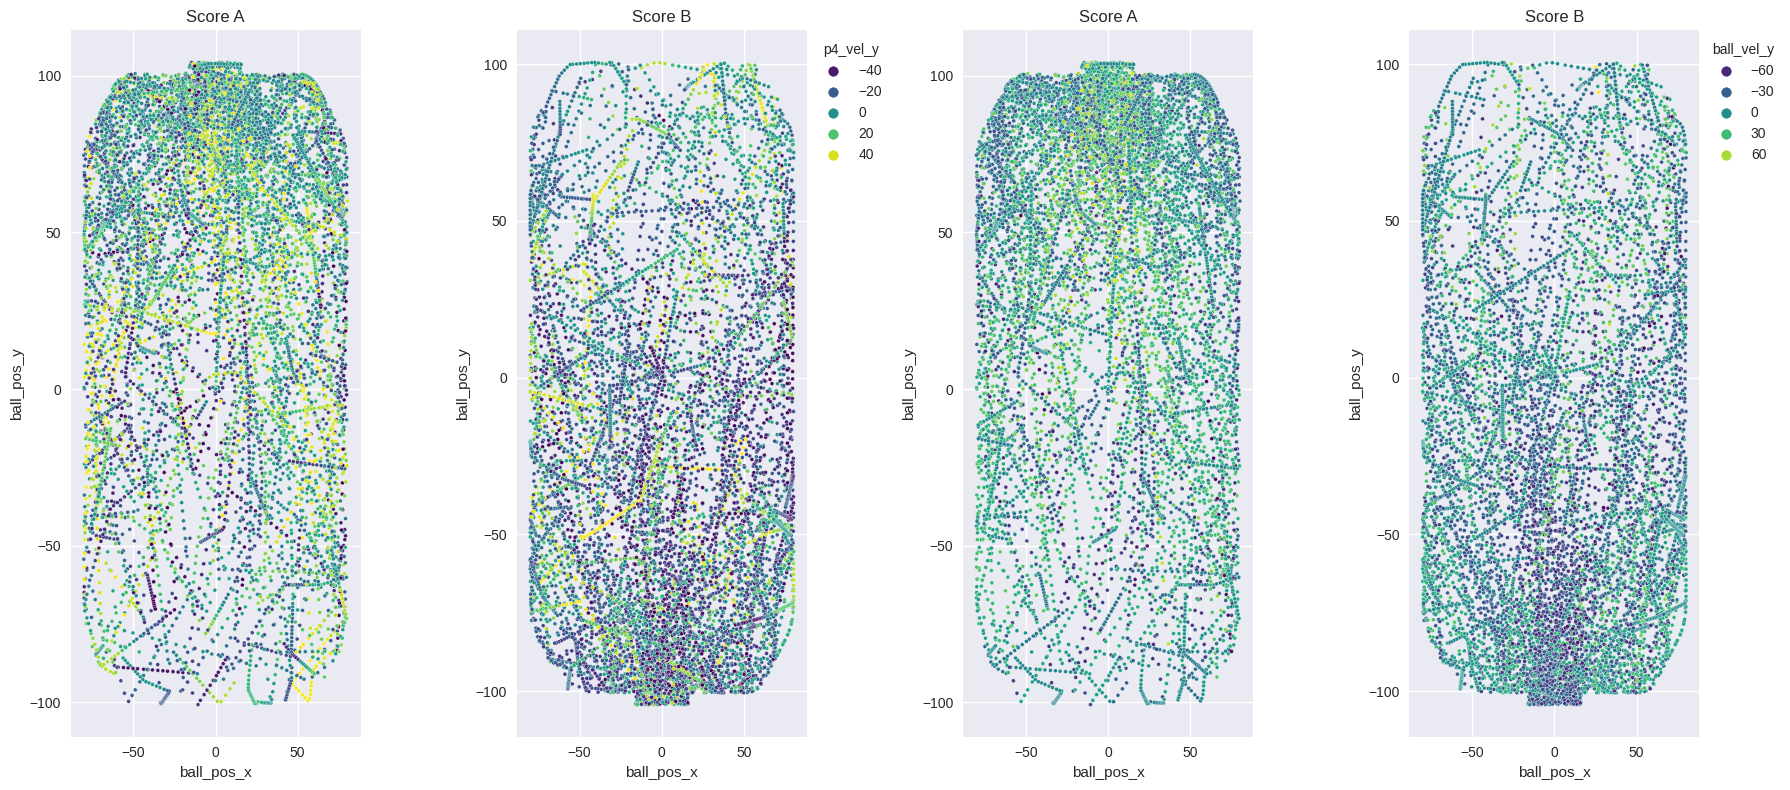

In [191]:
score_A = df0.query("team_A_scoring_within_10sec==1")[:10000]
score_B = df0.query("team_B_scoring_within_10sec==1")[:10000]

fig, ax = plt.subplots(1,4, figsize=(18, 8))

sns.scatterplot(data=score_A, x="ball_pos_x", y="ball_pos_y", hue="p4_vel_y", ax=ax[0], s=8, legend=False, palette=pal).set_title("Score A")
b = sns.scatterplot(data=score_B, x="ball_pos_x", y="ball_pos_y", hue="p4_vel_y",ax=ax[1], s=8, palette=pal)
b.set_title("Score B")
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(data=score_A, x="ball_pos_x", y="ball_pos_y", hue="ball_vel_y", ax=ax[2], s=8, legend=False,  palette=pal).set_title("Score A")
b = sns.scatterplot(data=score_B, x="ball_pos_x", y="ball_pos_y", hue="ball_vel_y",ax=ax[3], s=8,  palette=pal)
b.set_title("Score B")
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

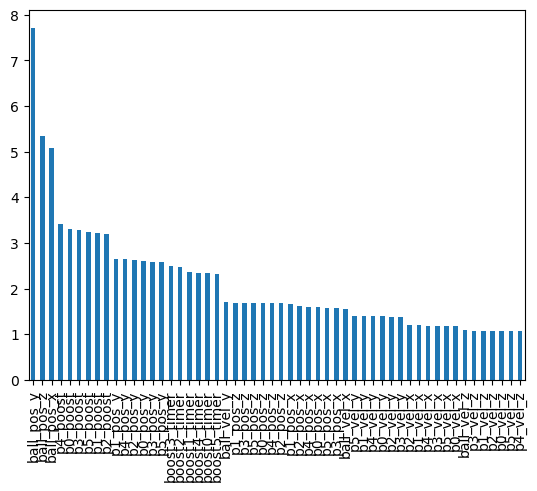

In [8]:
def plot_vif(df):
    vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])
    vif.index = df.columns
    vif.sort_values( ascending=False).plot.bar()

plot_vif(X)

It occures that the most important is vallocity of players and position of ball on y axis, additionaly ball position is correlate with position of players. 

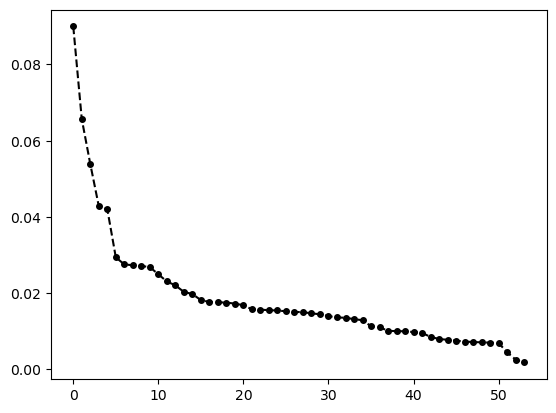

In [5]:
X_train_scale = QuantileTransformer().fit_transform(X)

pca = PCA()

pca.fit(X_train_scale)
plt.plot(pca.explained_variance_ratio_, 'o--', markersize=4, color="black")

<AxesSubplot:ylabel='None'>

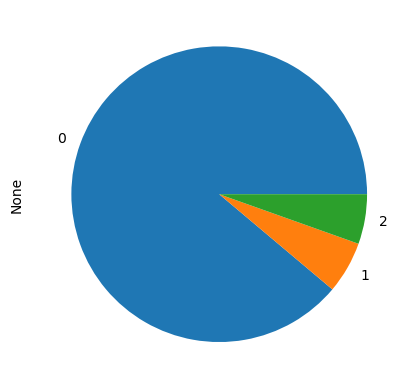

In [27]:
yAB = y.apply(lambda row: 1 if row[0] == 1 else 2 if row[1] == 1 else 0, axis=1)
yAB.groupby(yAB).count().plot.pie()

In [124]:
def calc_cm(model, k, X, y, w=None):
    nclasses = len(np.unique(y))

    act_y = np.empty([]).astype(int)
    pred_y = np.empty([]).astype(int)

    for train_idx, test_idx in k.split(X, y):
        if w:
            model.fit(X[train_idx], y[train_idx], eval_set=[(X[test_idx], y[test_idx])], sample_weight=w[train_idx], early_stopping_rounds=8)
        else:
            model.fit(X[train_idx], y[train_idx], eval_set=[(X[test_idx], y[test_idx])], early_stopping_rounds=8)


        act_y = np.append(act_y, y[test_idx])
        pred = model.predict(X[test_idx])
        pred_y = np.append(pred_y, pred)
    return act_y, pred_y


In [119]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=yAB
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1999)
clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=1999, use_label_encoder=False,  objective ='reg:logistic', eval_metric="auc")
act_y, pred_y = calc_cm(clf, kf, X.to_numpy(), yAB.to_numpy(), sample_weights)

[0]	validation_0-auc:0.79244
[1]	validation_0-auc:0.84367
[2]	validation_0-auc:0.86712
[3]	validation_0-auc:0.88273
[4]	validation_0-auc:0.89520
[5]	validation_0-auc:0.90259
[6]	validation_0-auc:0.91316
[7]	validation_0-auc:0.92146
[8]	validation_0-auc:0.92651
[9]	validation_0-auc:0.93071
[10]	validation_0-auc:0.93361
[11]	validation_0-auc:0.93752
[12]	validation_0-auc:0.94037
[13]	validation_0-auc:0.94234
[14]	validation_0-auc:0.94473
[15]	validation_0-auc:0.94749
[16]	validation_0-auc:0.94974
[17]	validation_0-auc:0.95222
[18]	validation_0-auc:0.95420
[19]	validation_0-auc:0.95588
[20]	validation_0-auc:0.95789
[21]	validation_0-auc:0.96011
[22]	validation_0-auc:0.96172
[23]	validation_0-auc:0.96349
[24]	validation_0-auc:0.96550
[25]	validation_0-auc:0.96696
[26]	validation_0-auc:0.96865
[27]	validation_0-auc:0.97010
[28]	validation_0-auc:0.97139
[29]	validation_0-auc:0.97251
[30]	validation_0-auc:0.97341
[31]	validation_0-auc:0.97422
[32]	validation_0-auc:0.97525
[33]	validation_0-au

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(act_y, pred_y):
    labels = ["No score", "A score", "B score"]
    cm = confusion_matrix(act_y, pred_y)
    sns.heatmap(cm, annot=True, yticklabels=labels, xticklabels=labels)
    plt.xlabel("predicted")
    plt.ylabel("Actual")
    plt.show()
    print(classification_report(act_y, pred_y))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    337583
           1       0.82      0.98      0.89     21617
           2       0.80      0.97      0.88     20672

    accuracy                           0.97    379872
   macro avg       0.87      0.97      0.92    379872
weighted avg       0.98      0.97      0.97    379872



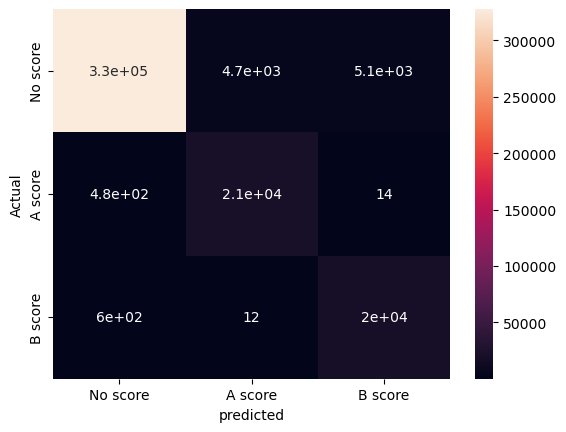

In [120]:
plot_confusion_matrix(act_y, pred_y)

<AxesSubplot:ylabel='None'>

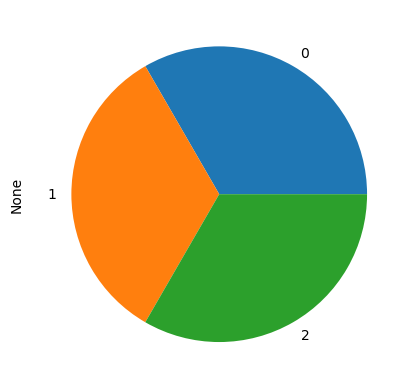

In [122]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=1999)
X_res, yAB_res = sm.fit_resample(X, yAB)
yAB_res.groupby(yAB_res).count().plot.pie()

In [126]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1999)
clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=1999, use_label_encoder=False,  objective ='reg:logistic', eval_metric="auc")
act_y, pred_y = calc_cm(clf, kf, X_res.to_numpy(), yAB_res.to_numpy())

[0]	validation_0-auc:0.89713
[1]	validation_0-auc:0.92657
[2]	validation_0-auc:0.94233
[3]	validation_0-auc:0.95297
[4]	validation_0-auc:0.96112
[5]	validation_0-auc:0.96663
[6]	validation_0-auc:0.97060
[7]	validation_0-auc:0.97405
[8]	validation_0-auc:0.97676
[9]	validation_0-auc:0.97987
[10]	validation_0-auc:0.98248
[11]	validation_0-auc:0.98495
[12]	validation_0-auc:0.98629
[13]	validation_0-auc:0.98791
[14]	validation_0-auc:0.98904
[15]	validation_0-auc:0.99032
[16]	validation_0-auc:0.99126
[17]	validation_0-auc:0.99212
[18]	validation_0-auc:0.99273
[19]	validation_0-auc:0.99334
[20]	validation_0-auc:0.99379
[21]	validation_0-auc:0.99448
[22]	validation_0-auc:0.99517
[23]	validation_0-auc:0.99555
[24]	validation_0-auc:0.99591
[25]	validation_0-auc:0.99630
[26]	validation_0-auc:0.99674
[27]	validation_0-auc:0.99701
[28]	validation_0-auc:0.99734
[29]	validation_0-auc:0.99745
[30]	validation_0-auc:0.99771
[31]	validation_0-auc:0.99789
[32]	validation_0-auc:0.99813
[33]	validation_0-au

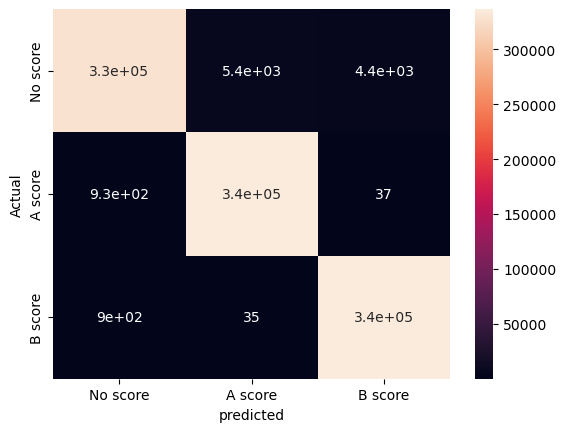

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    337583
           1       0.98      1.00      0.99    337582
           2       0.99      1.00      0.99    337582

    accuracy                           0.99   1012747
   macro avg       0.99      0.99      0.99   1012747
weighted avg       0.99      0.99      0.99   1012747



In [129]:
plot_confusion_matrix(act_y, pred_y)

In [132]:
clf.fit(X_res, yAB_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=1999, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [134]:
exp = shap.TreeExplainer(clf)

In [ ]:
shap_values = exp.shap_values(X[:1000])

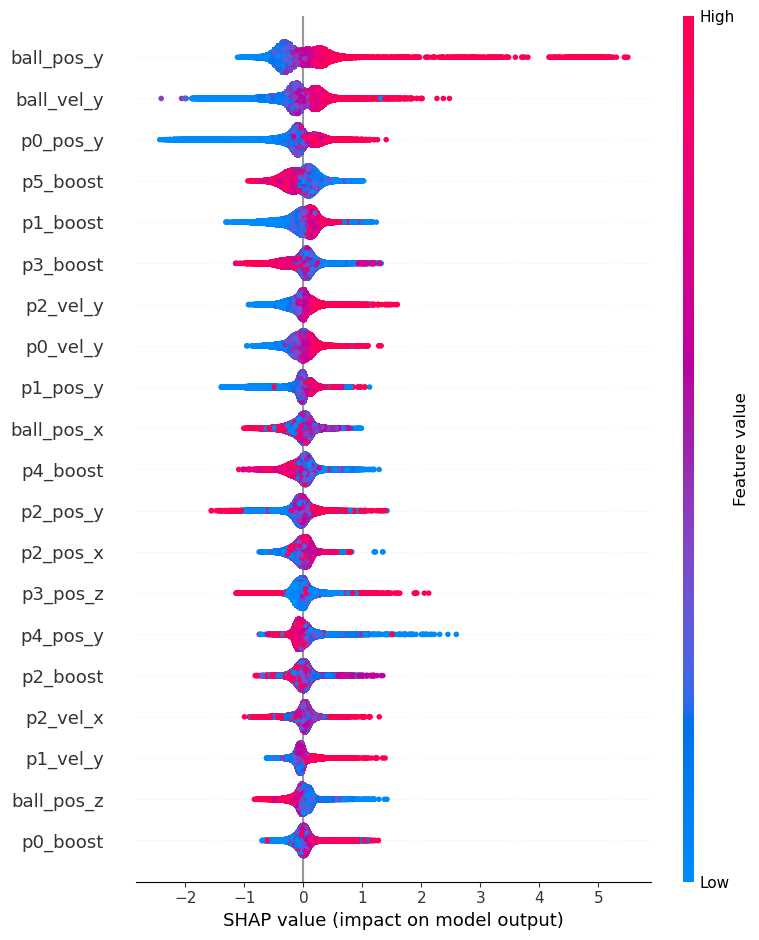

In [12]:
shap.summary_plot(shap_values, X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


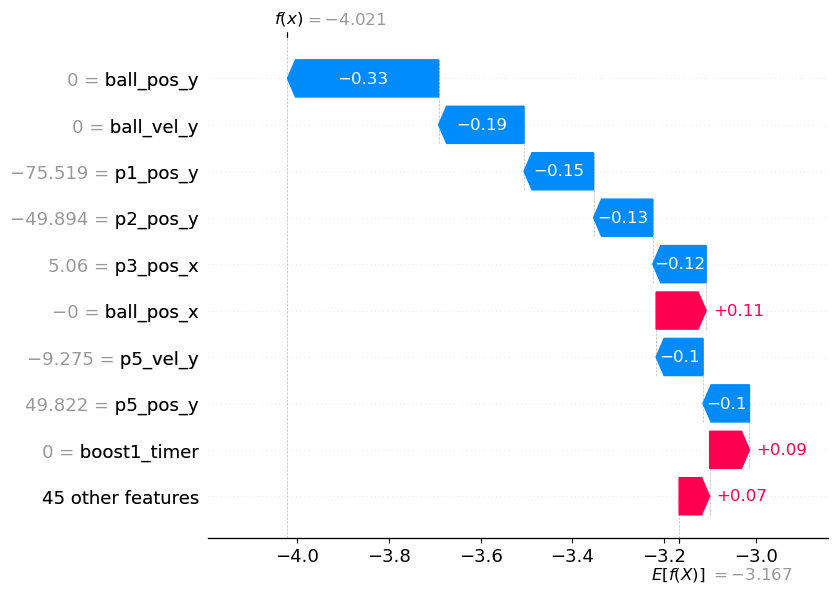

In [20]:
explainer = shap.Explainer(clf)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

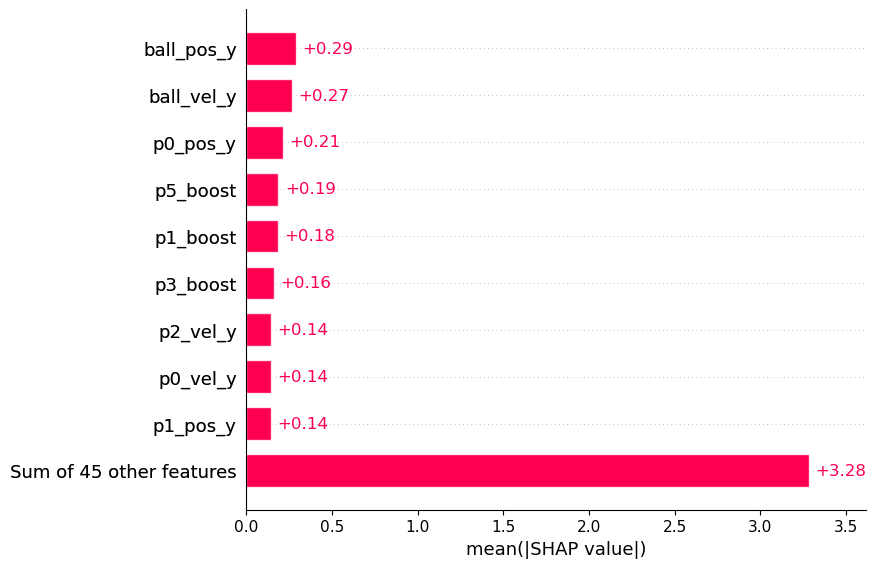

In [23]:
shap.plots.bar(shap_values)

In [ ]:
def display_bars(col, name_A, name_B, method1, method2):
    a = pd.Series(method1, name=name_A)
    b = pd.Series(method2, name=name_B)
    df = pd.merge(a, b, right_index=True, left_index=True)
    df.set_index(col, inplace=True)

    plt.style.use("seaborn")
    df.sort_values(by=df.columns[0], ascending=False).plot.bar(figsize=(18, 8))
    plt.show()

In [ ]:
display_bars(X_train.columns, "team_A_score_10sec", "team_B_score_10_sec", mutual_info_classif(X_train, y_train.iloc[:, 0]), mutual_info_classif(X_train, y_train.iloc[:, 1]))

tree = RandomForestClassifier(n_estimators=50)
tree2 = clone(tree) 
display_bars(X_train.columns,  "team_A_score_10sec", "team_B_score_10_sec",tree.fit(X_train, y_train.iloc[:, 0]).feature_importances_, tree2.fit(X_train, y_train.iloc[:, 1]).feature_importances_)

In [ ]:
selector = SelectKBest(mutual_info_classif, k=.7)
selector2 = clone(selector)
selector.fit(X_train, y_train.iloc[:, 0])
selector2.fit(X_train, y_train.iloc[:, 1])
print(selector.get_support())
X_train_imp_A = X_train.columns[selector.get_support()]
X_train_imp_B = X_train.columns[selector2.get_support()]